### Global Salaries in Cybersecurity 

##### Import Data

In [1]:
import numpy as np 
import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pycountry_convert as pc

In [2]:
main_df = pd.read_csv("salaries.csv")

##### EDA

In [3]:
display(main_df.head())

print(f"\nDimensions: {main_df.shape[0]} rows × {main_df.shape[1]} columns")

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,DevSecOps Engineer,143893,USD,143893,US,0,US,M
1,2025,SE,FT,DevSecOps Engineer,129706,USD,129706,US,0,US,M
2,2025,MI,FT,Software Engineer,160000,USD,160000,US,0,US,M
3,2025,MI,FT,Software Engineer,128000,USD,128000,US,0,US,M
4,2025,SE,FT,Security Engineer,220000,USD,220000,US,100,US,M



Dimensions: 48036 rows × 11 columns


In [4]:
print("Null values in train_df:")
print(main_df.isnull().sum())

Null values in train_df:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


In [5]:
# check for unique values in main_df

print("Unique values in train_df:")
for column in main_df.columns:
    print(f"{column}: {main_df[column].nunique()} unique values")

Unique values in train_df:
work_year: 6 unique values
experience_level: 4 unique values
employment_type: 4 unique values
job_title: 377 unique values
salary: 5782 unique values
salary_currency: 22 unique values
salary_in_usd: 6436 unique values
employee_residence: 87 unique values
remote_ratio: 3 unique values
company_location: 86 unique values
company_size: 3 unique values


In [6]:
# Numerical columns: calculate range
numerical_columns = main_df.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    print(f"{column}: Range = {main_df[column].min()} to {main_df[column].max()}")

# Categorical columns: list unique values
categorical_columns = main_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    unique_values = main_df[column].unique()
    print(f"{column}: Unique values = {', '.join(map(str, unique_values))}")

work_year: Range = 2020 to 2025
salary: Range = 14400 to 600000000
salary_in_usd: Range = 15061 to 750000
remote_ratio: Range = 0 to 100
experience_level: Unique values = SE, MI, EN, EX
employment_type: Unique values = FT, CT, PT, FL
job_title: Unique values = DevSecOps Engineer, Software Engineer, Security Engineer, Security Architect, Security Analyst, Program Manager, Intelligence Analyst, Analyst, Manager, Customer Success Engineer, Malware Analyst, Systems Administrator, System Engineer, Product Owner, Consultant, Information Security Risk Specialist, Threat Analyst, Vulnerability Engineer, Systems Architect, Network Engineer, Systems Engineer, Security Sales Specialist, Compliance Specialist, Data Analyst, Cyber Security, Technical Account Manager, Associate, Enterprise Architect, Full Stack Developer, Risk Analyst, Threat Intelligence Analyst, DevSecOps, Security Specialist, Data Engineer, Isso, Software Developer, Product Manager, SIEM Engineer, Compliance Officer, Site Reliabi

In [35]:
main_df.dtypes

work_year             object
experience_level       int64
employment_type       object
job_title             object
salary_in_usd          int64
remote_ratio           int64
company_size           int64
employee_continent    object
company_continent     object
dtype: object

##### Preprocessing

In [7]:
# we don't need the salary since it's converted to USD
def drop_cols(df):
    df.drop(columns=['salary', 'salary_currency'], inplace=True)
    return df

main_df = drop_cols(main_df)

In [8]:
# map country codes to continent codes

def map_to_continent(country_code):
    continent_map = {
        "North America": "NA",
        "Europe": "EU",
        "Asia": "AS",
        "Oceania": "OC",
        "South America": "SA",
        "Africa": "AF",
        "Other": "OT"
    }
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_map.get(continent_name, "OT")
    except:
        return "OT"

main_df["employee_continent"] = main_df["employee_residence"].apply(map_to_continent)
main_df["company_continent"] = main_df["company_location"].apply(map_to_continent)

main_df.drop(columns=["employee_residence", "company_location"], inplace=True)

In [9]:
# change work_year as a categorical variable

main_df["work_year"] = main_df["work_year"].astype(str)

In [10]:
main_df['job_title'].value_counts()

job_title
Security Engineer                             12276
Security Analyst                               3863
Manager                                        2020
Software Engineer                              1823
Security Architect                             1405
                                              ...  
Threat Hunting Lead                               1
Enterprise Security Engineer                      1
Corporate Infrastructure Security Engineer        1
Lead Application Security Engineer                1
Concierge Security Engineer                       1
Name: count, Length: 377, dtype: int64

In [11]:
def normalize_title(title):
    title = title.lower()
    if "devsecops" in title:
        return "DevSecOps Engineer"
    elif "devops" in title or "platform engineer" in title or "cloud engineer" in title or "site reliability" in title:
        return "DevOps Engineer"
    elif "software engineer" in title or "developer" in title or "test engineer" in title or "principal engineer" in title:
        return "Software Engineer"
    elif "security architect" in title or "solution architect" in title or "solutions architect" in title:
        return "Security Architect"
    elif any(x in title for x in [
        "security engineer", "security operations", "security administrator", "security specialist",
        "information security officer", "cyber engineer", "firewall engineer",
        "detection engineer", "infrastructure engineer", "splunk engineer"
    ]):
        return "Security Engineer"
    elif any(x in title for x in [
        "security analyst", "soc analyst", "incident response", "incident responder",
        "threat", "cyber security", "privacy engineer", "vulnerability analyst",
        "cyber analyst", "risk analyst", "digital network exploitation analyst"
    ]):
        return "Security Analyst"
    elif any(x in title for x in ["systems administrator", "system administrator", "systems engineer"]):
        return "Systems Administrator"
    elif "penetration tester" in title or "red team" in title:
        return "Penetration Tester"
    elif "security consultant" in title or ("consultant" in title and "security" in title) or title == "consultant":
        return "Security Consultant"
    elif any(x in title for x in ["compliance", "grc analyst", "security control assessor", "it auditor"]):
        return "Compliance Analyst"
    elif "network engineer" in title:
        return "Network Engineer"
    elif "program manager" in title:
        return "Program Manager"
    elif "sales engineer" in title or "solutions engineer" in title:
        return "Sales Engineer"
    elif "security researcher" in title or "reverse engineer" in title:
        return "Security Researcher"
    elif any(x in title for x in ["manager", "lead", "head"]):
        return "Manager"
    elif "analyst" in title:
        return "Analyst"
    elif "associate" in title:
        return "Associate"
    else:
        return "Other"


In [12]:
# normalize job titles
main_df['job_title'] = main_df['job_title'].apply(normalize_title)

In [13]:
# ordinal encoding for experience level and company size

experience_map = {"EN": 0, "MI": 1, "SE": 2, "EX": 3}
company_size_map = {"S": 0, "M": 1, "L": 2}

main_df["experience_level"] = main_df["experience_level"].map(experience_map)
main_df["company_size"] = main_df["company_size"].map(company_size_map)

In [ ]:
numeric_data = main_df.select_dtypes(include=['int64', 'float64']).drop(columns=['Unnamed: 0', 'ID'], errors='ignore')
correlation_matrix = main_df.corr()
print("\nCorrelation matrix:")

In [ ]:
# check for outliers in numerical columns
def check_outliers(df):
    for column in df.select_dtypes(include=['int64', 'float64']).columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f"{column}: {len(outliers)} outliers")

In [14]:
categorical_columns = [
    "employment_type", "job_title", "employee_continent", "company_continent", "work_year"
]

# One-hot encode categorical vars
df_encoded = pd.get_dummies(main_df, columns=categorical_columns)
# df_encoded = pd.get_dummies(main_df, columns=categorical_columns, drop_first=True)

In [15]:
df_encoded.head()

,experience_level,salary_in_usd,remote_ratio,company_size,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,job_title_Analyst,job_title_Associate,...,company_continent_NA,company_continent_OC,company_continent_OT,company_continent_SA,work_year_2020,work_year_2021,work_year_2022,work_year_2023,work_year_2024,work_year_2025
0,2,143893,0,1,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
1,2,129706,0,1,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,1,160000,0,1,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,1,128000,0,1,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,2,220000,100,1,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True


##### Training and Validation

In [16]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=["salary_in_usd"])
y = df_encoded["salary_in_usd"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.linear_model import LinearRegression

# model linear regression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [31]:
def smape(actual, forecast):
    value = 100 * np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))
    return round(float(value), 2)
def accuracy(y_true, y_pred):
    value = 100 - smape(y_true, y_pred)
    return round(float(value), 2)

In [32]:
lr_train = model.predict(X_valid)
smape(y_valid, lr_train)

30.27

69.73


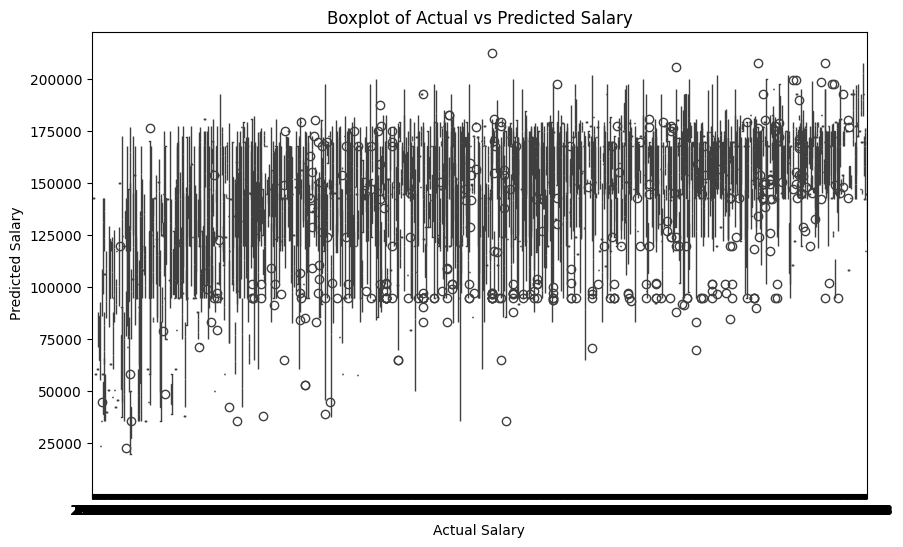

In [33]:
# check accuracy percentage
print(accuracy(y_valid, lr_train))
# check for outliers
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_valid, y=lr_train)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Boxplot of Actual vs Predicted Salary")
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, r2_score


# Evaluasi
mse = mean_squared_error(y_valid, lr_train)
r2 = r2_score(y_valid, lr_train)

print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Squared Error: 3305278195.1595807
R² Score: 0.17888567103197206


In [23]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [24]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [25]:
rf_train = rf_model.predict(X_valid)
smape(y_valid, rf_train)

mse = mean_squared_error(y_valid, rf_train)
r2 = r2_score(y_valid, rf_train)

print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Squared Error: 3269286506.5088115
R² Score: 0.18782691274596208


In [26]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [27]:
xgb_train = xgb_model.predict(X_valid)
smape(y_valid, xgb_train)

mse = mean_squared_error(y_valid, xgb_train)
r2 = r2_score(y_valid, xgb_train)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 3253865865.3124633
R² Score: 0.19165778160095215
